In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from pmsm_tools import phi_eval_2,i_eval_2,phi_eval_3
import scipy.io as sio


In [2]:
%matplotlib widget

In [3]:
data_i2p = np.load('pmsm_i2phi.npz')

Phi_d_i2p,Phi_q_i2p = data_i2p['phi_d'],data_i2p['phi_q']
I_d_i2p,I_q_i2p = data_i2p['i_d'].astype(np.float64),data_i2p['i_q'].astype(np.float64)
Theta_i2p = data_i2p['theta'].astype(np.float64)
Torque_i2p = data_i2p['torque']


def val2idx_i2p(i_d,i_q,theta,I_d_i2p,I_q_i2p,Theta_i2p):
    '''
    Returns indices in vectors I_d, I_q and Theta for given i_d, i_q and theta values.
    '''
    
    i_d_min,i_d_max,N_i_d = I_d_i2p[0],I_d_i2p[-1],len(I_d_i2p)
    i_q_min,i_q_max,N_i_q = I_q_i2p[0],I_q_i2p[-1],len(I_q_i2p)
    theta_min,theta_max,N_th = Theta_i2p[0],Theta_i2p[-1],len(Theta_i2p)
   
    i_d_idx = int((i_d - i_d_min)/(i_d_max - i_d_min)*(N_i_d))
    i_q_idx = int((i_q - i_q_min)/(i_q_max - i_q_min)*(N_i_q))
    theta_idx = int((theta - theta_min)/(theta_max - theta_min)*(N_th))
    
    return i_d_idx,i_q_idx,theta_idx


## Classical model parameters

In [4]:
Phi_m = Phi_d_i2p[10,10,0]
L_d = (Phi_d_i2p[11,10,0]-Phi_d_i2p[9,10,0])/(I_d_i2p[11]-I_d_i2p[9])
L_q = (Phi_q_i2p[10,11,0]-Phi_q_i2p[10,9,0])/(I_q_i2p[11]-I_q_i2p[9])

R_s = 0.07
N_pp = 4

R_l = 10.0

omega_r = 7200*2*np.pi/60 #3000*2*np.pi/60/N_pp

## Classic linear model with currents as states

In [5]:
Dt = L_d/(R_s + R_l)/10
times = np.arange(0.0,0.01,Dt)
N_t = len(times)
Z = {'t':times}
Z.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z.update({'v_a':np.zeros(N_t),'v_b':np.zeros(N_t),'v_c':np.zeros(N_t),'tau_e':np.zeros(N_t)})


i_d = 0.0
i_q = 0.0
theta = 0.0


for it,t in enumerate(times):
    
    omega_e = omega_r*N_pp
    
    v_d = -i_d*R_l
    v_q = -i_q*R_l
    
    dtheta = omega_e
    di_d = 1/L_d*(v_d - R_s*i_d - omega_e*L_q*i_q)
    di_q = 1/L_q*(v_q - R_s*i_q + omega_e*(Phi_m + L_d*i_d))
    tau_e = 3/2*N_pp*(Phi_m*i_q + (L_d - L_q)*i_d*i_q)
                  
    Z['v_d'][it],Z['v_q'][it],Z['i_d'][it],Z['i_q'][it],Z['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    
    Z['v_a'][it] = 2/3*(v_d*np.cos(theta)           + v_q*np.sin(theta));
    Z['v_b'][it] = 2/3*(v_d*np.cos(theta-2/3*np.pi) + v_q*np.sin(theta-2/3*np.pi));
    Z['v_c'][it] = 2/3*(v_d*np.cos(theta-4/3*np.pi) + v_q*np.sin(theta-4/3*np.pi));

    i_d += Dt*di_d
    i_q += Dt*di_q
    theta += Dt*dtheta 
    
Z_1 = Z.copy()

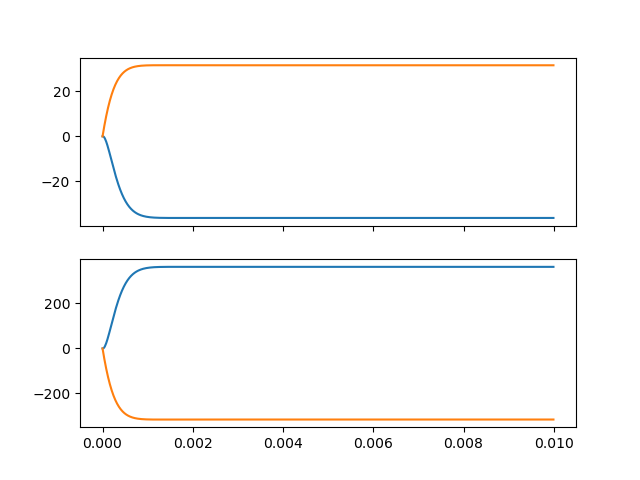

In [6]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_1['t'], Z_1['i_d'],label='i_d')
axes[0].plot(Z_1['t'], Z_1['i_q'],label='i_q')

axes[1].plot(Z_1['t'], Z_1['v_d'],label='v_d')
axes[1].plot(Z_1['t'], Z_1['v_q'],label='v_q')

## Linear model with currents as states and function for fluxes

In [7]:
Z_2 = {'t':times}
Z_2.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z_2.update({'v_a':np.zeros(N_t),'v_b':np.zeros(N_t),'v_c':np.zeros(N_t),'tau_e':np.zeros(N_t)})

N_t = len(times)

i_d = 0.0
i_q = 0.0
theta = 0.0

def phi_eval(theta,i_d,i_q):
    
    phi_d = Phi_m + L_d*i_d
    phi_q = L_q*i_q
    
    return phi_d,phi_q
    

for it,t in enumerate(times):
    
    phi_d,phi_q = phi_eval(theta,i_d,i_q)
    
    omega_e = omega_r*N_pp
    
    v_d = -i_d*R_l
    v_q = -i_q*R_l
    
    dtheta = omega_e
    di_d = 1/L_d*(v_d - R_s*i_d - omega_e*phi_q)
    di_q = 1/L_q*(v_q - R_s*i_q + omega_e*phi_d)
    tau_e = 3/2*N_pp*(phi_d*i_q - phi_q*i_d)
    
    Z_2['v_d'][it],Z_2['v_q'][it],Z_2['i_d'][it],Z_2['i_q'][it],Z_2['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    Z_2['v_a'][it] = v_d*np.cos(theta)           - v_q*np.sin(theta);
    Z_2['v_b'][it] = v_d*np.cos(theta-2/3*np.pi) - v_q*np.sin(theta-2/3*np.pi);
    Z_2['v_c'][it] = v_d*np.cos(theta-4/3*np.pi) - v_q*np.sin(theta-4/3*np.pi);
    
    # state updates
    i_d += Dt*di_d
    i_q += Dt*di_q
    theta += Dt*dtheta 
    

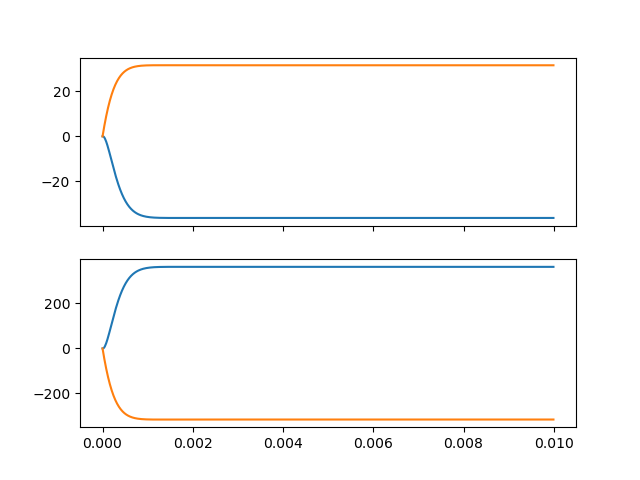

In [8]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_2['t'], Z_2['i_d'],label='i_d')
axes[0].plot(Z_2['t'], Z_2['i_q'],label='i_q')
axes[1].plot(Z_2['t'], Z_2['v_d'],label='v_d')
axes[1].plot(Z_2['t'], Z_2['v_q'],label='v_q')

## Linear model with fluxes as states and function for currents

In [9]:
N_t = len(times)

phi_d = Phi_m
phi_q = 0.0
theta = 0.0

Z_3 = {'t':times}
Z_3.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z_3.update({'v_a':np.zeros(N_t),'v_b':np.zeros(N_t),'v_c':np.zeros(N_t),'tau_e':np.zeros(N_t)})

def i_eval(theta,phi_d,phi_q):
    
    i_d = (phi_d - Phi_m)/L_d
    i_q = phi_q/L_q
    
    return i_d,i_q
    

for it,t in enumerate(times):
    
    i_d,i_q = i_eval(theta,phi_d,phi_q)
    
    omega_e = omega_r*N_pp
    
    v_d = -i_d*R_l
    v_q = -i_q*R_l
    
    dtheta = omega_e
    dphi_d = (v_d - R_s*i_d - omega_e*phi_q)
    dphi_q = (v_q - R_s*i_q + omega_e*phi_d)
    tau_e = 3/2*N_pp*(phi_d*i_q - phi_q*i_d)
    
    # recording
    Z_3['v_d'][it],Z_3['v_q'][it],Z_3['i_d'][it],Z_3['i_q'][it],Z_3['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    Z_3['v_a'][it] = v_d*np.cos(theta)           - v_q*np.sin(theta);
    Z_3['v_b'][it] = v_d*np.cos(theta-2/3*np.pi) - v_q*np.sin(theta-2/3*np.pi);
    Z_3['v_c'][it] = v_d*np.cos(theta-4/3*np.pi) - v_q*np.sin(theta-4/3*np.pi);
    
    # state updates
    phi_d += Dt*dphi_d
    phi_q += Dt*dphi_q
    theta += Dt*dtheta 


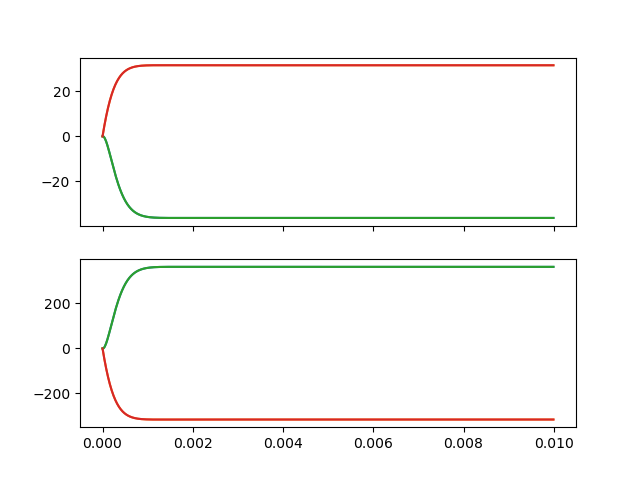

In [10]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_2['t'], Z_2['i_d'],label='$\phi$ model: i_d')
axes[0].plot(Z_2['t'], Z_2['i_q'],label='$\phi$ model: i_q')

axes[0].plot(Z_3['t'], Z_3['i_d'],label='$i$ model: i_d')
axes[0].plot(Z_3['t'], Z_3['i_q'],label='$i$ model: i_q')

axes[1].plot(Z_2['t'], Z_2['v_d'],label='v_d')
axes[1].plot(Z_2['t'], Z_2['v_q'],label='v_q')

axes[1].plot(Z_3['t'], Z_3['v_d'],label='v_d')
axes[1].plot(Z_3['t'], Z_3['v_q'],label='v_q')

## Nonlinear model with currents as states and LUT for fluxes

In [23]:
Dt = 1e-6
times = np.arange(0,0.01,Dt)
N_t = len(times)

Z_4 = {'t':times}
Z_4.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z_4.update({'v_a':np.zeros(N_t),'v_b':np.zeros(N_t),'v_c':np.zeros(N_t),'tau_e':np.zeros(N_t)})
Z_4.update({'i_a':np.zeros(N_t),'i_b':np.zeros(N_t),'i_c':np.zeros(N_t)})
Z_4.update({'phi_d':np.zeros(N_t),'phi_q':np.zeros(N_t)})
Z_4.update({'tau_e':np.zeros(N_t),'tau_e_lut':np.zeros(N_t)})

i_d = 0.0
i_q = 0.0
theta_r = 0.0
theta_e = 0.0
theta_t = 0.0

R_l = 100

for it,t in enumerate(times):
    
    phi_d,phi_q,torque,L_s = phi_eval_3(i_d,i_q,theta_t/(2*np.pi)*30,Phi_d_i2p,Phi_q_i2p,Torque_i2p,I_d_i2p,I_q_i2p,Theta_i2p)
    
    omega_e = omega_r*N_pp
    omega_t = omega_e*3
    
    v_d = -i_d*R_l
    v_q = -i_q*R_l
    
    dtheta_r = omega_r
    dtheta_e = omega_e
    dtheta_t = omega_t
    
    #dphi_d = L_dd*di_d + L_dq*di_q -> di_d_L
    #dphi_q = L_qd*di_q + L_qq*di_q -> di_q_L
    
    di_d_L = (v_d - R_s*i_d - omega_e*phi_q)
    di_q_L = (v_q - R_s*i_q + omega_e*phi_d)
    di_dq_L = np.array([di_d_L,di_q_L])
    di_dq = np.linalg.solve(L_s,di_dq_L)
    #di_dq = di_dq_L
     
    tau_e = 3/2*N_pp*(phi_d*i_q - phi_q*i_d)
    
    Z_4['v_d'][it],Z_4['v_q'][it],Z_4['i_d'][it],Z_4['i_q'][it],Z_4['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    Z_4['v_a'][it] = 2/3*(v_d*np.cos(theta_e)           + v_q*np.sin(theta_e));
    Z_4['v_b'][it] = 2/3*(v_d*np.cos(theta_e-2/3*np.pi) + v_q*np.sin(theta_e-2/3*np.pi));
    Z_4['v_c'][it] = 2/3*(v_d*np.cos(theta_e-4/3*np.pi) + v_q*np.sin(theta_e-4/3*np.pi));
    Z_4['i_a'][it] = 2/3*(i_d*np.cos(theta_e)           + i_q*np.sin(theta_e));
    Z_4['i_b'][it] = 2/3*(i_d*np.cos(theta_e-2/3*np.pi) + i_q*np.sin(theta_e-2/3*np.pi));
    Z_4['i_c'][it] = 2/3*(i_d*np.cos(theta_e-4/3*np.pi) + i_q*np.sin(theta_e-4/3*np.pi));    
    Z_4['phi_d'][it],Z_4['phi_q'][it] = phi_d,phi_q
    Z_4['tau_e'][it],Z_4['tau_e_lut'][it] = tau_e,torque
    # state updates
    i_d += Dt*di_dq[0]
    i_q += Dt*di_dq[1]
    theta_r += Dt*dtheta_r
    theta_e += Dt*dtheta_e
    theta_t += Dt*dtheta_t
    
    if theta_r>2*np.pi: theta_r = 0.0
    if theta_e>2*np.pi: theta_e = 0.0
    if theta_t>2*np.pi: theta_t = 0.0

In [27]:
L_s

array([[1.31418155e-03, 2.05250885e-05],
       [1.03287388e-06, 3.58544170e-03]])

#### Results

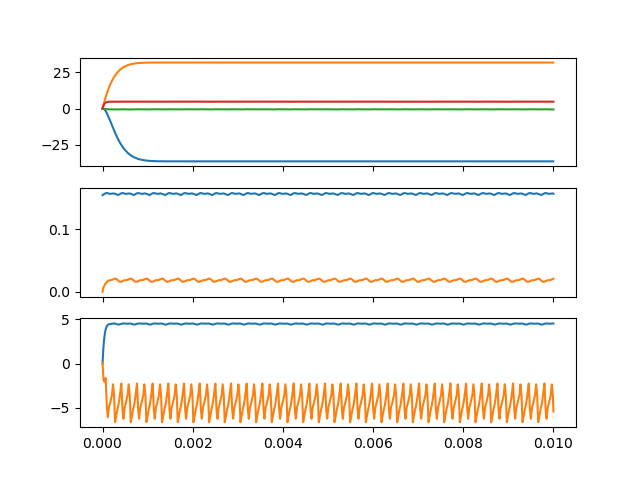

In [24]:
fig,axes = plt.subplots(nrows=3, sharex=True)
axes[0].plot(Z_3['t'], Z_3['i_d'],label='$\phi$ model: i_d')
axes[0].plot(Z_3['t'], Z_3['i_q'],label='$\phi$ model: i_q')
axes[0].plot(Z_4['t'], Z_4['i_d'],label='$\phi$ model: i_d')
axes[0].plot(Z_4['t'], Z_4['i_q'],label='$\phi$ model: i_q')

axes[1].plot(Z_4['t'], Z_4['phi_d'],label='$\phi$ model: i_d')
axes[1].plot(Z_4['t'], Z_4['phi_q'],label='$\phi$ model: i_q')

axes[2].plot(Z_4['t'], Z_4['tau_e'],label='$\phi$ model: i_d')
axes[2].plot(Z_4['t'], Z_4['tau_e_lut'],label='$\phi$ model: i_q')


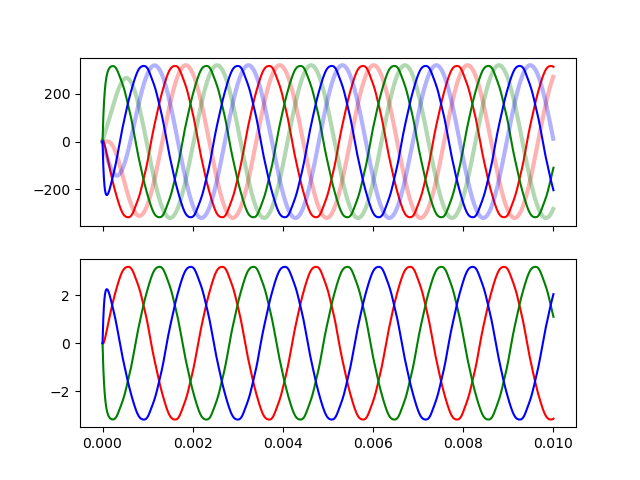

In [26]:
fig,axes = plt.subplots(nrows=2, sharex=True)

colors = ['r','g','b']
for it,item in enumerate(['v_a','v_b','v_c']):
    axes[0].plot(Z_1['t'], Z_1[item],label=item,color=colors[it], alpha = 0.3, lw= 3)
    axes[0].plot(Z_4['t'], Z_4[item],label=item,color=colors[it])

for it,item in enumerate(['i_a','i_b','i_c']):
    axes[1].plot(Z_4['t'], Z_4[item],label=item,color=colors[it])

## Nonlinear model with fluxes as states and LUT for currents

In [7]:
data_p2i = np.load('phi2i_21.npz')

I_d_p2i,I_q_p2i = data_p2i['i_d'],data_p2i['i_q']
Phi_d_p2i,Phi_q_p2i = data_p2i['phi_d'],data_p2i['phi_q']
Theta_p2i = data_p2i['theta']

In [100]:
dqz = np.array([0.5,0.0,0.0],dtype=np.float64)
abc = ipark_2( dqz, 4.0)
dqz = park_2( abc, 4.0)

print(abc,dqz)

[-0.32682181 -0.16429419  0.491116  ] [ 5.00000000e-01  8.32667268e-17 -1.85037171e-17]


In [109]:
N_t = len(times)

phi_d = Phi_m
phi_q = 0.0
theta_r = 0.0
theta_e = 0.0
theta_t = 0.0
v_dqz = np.zeros((3))

Z_5 = {'t':times}
Z_5.update({'v_d':np.zeros(N_t),'v_q':np.zeros(N_t),'i_d':np.zeros(N_t),'i_q':np.zeros(N_t)})
Z_5.update({'tau_e':np.zeros(N_t),'v_abc':np.zeros((N_t,3))})

R_l = 100
def i_eval(theta,phi_d,phi_q):
    
    i_d = (phi_d - Phi_m)/L_d
    i_q = phi_q/L_q
    
    return i_d,i_q
    

for it,t in enumerate(times):
    
    #theta_e 0-2pi -> theta  0-30
    
    # model
    i_d,i_q = i_eval_2(phi_d,phi_q,np.rad2deg(theta_t),Phi_d_p2i,Phi_q_p2i,I_d_p2i,I_q_p2i,Theta_p2i)
    
    omega_e = omega_r*N_pp
    
    v_d = -i_d*R_l
    v_q = -i_q*R_l
    
    dtheta_r = omega_r
    dtheta_e = omega_e
    dtheta_t = omega_r
    dphi_d = (v_d - R_s*i_d - omega_e*phi_q)
    dphi_q = (v_q - R_s*i_q + omega_e*phi_d)
    tau_e = 3/2*N_pp*(phi_d*i_q - phi_q*i_d)
    
    v_dqz[0] = v_d
    v_dqz[1] = v_q
    
    v_abc = ipark_2(v_dqz,theta_e)
    
    # recording
    Z_5['v_d'][it],Z_5['v_q'][it],Z_5['i_d'][it],Z_5['i_q'][it],Z_5['tau_e'][it] = v_d,v_q,i_d,i_q,tau_e
    Z_5['v_abc'][it,:] = v_abc

    
    # state updates
    phi_d += Dt*dphi_d
    phi_q += Dt*dphi_q   
    theta_r += Dt*dtheta_r
    theta_e += Dt*dtheta_e
    theta_t += Dt*dtheta_t
    
    if theta_r>2*np.pi: theta_r = 0.0
    if theta_e>2*np.pi: theta_e = 0.0
    if theta_t>np.deg2rad(120/N_pp): theta_t = 0.0

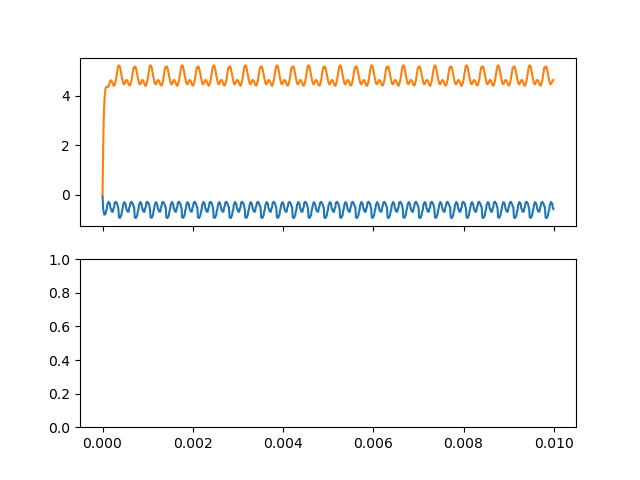

In [111]:
fig,axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(Z_5['t'], Z_5['i_d'],label='$\phi$ model: i_d')
axes[0].plot(Z_5['t'], Z_5['i_q'],label='$\phi$ model: i_q')

#axes[0].plot(Z_4['t'], Z_4['i_d'],label='$\phi$ model: i_d')
#axes[0].plot(Z_4['t'], Z_4['i_q'],label='$\phi$ model: i_q')

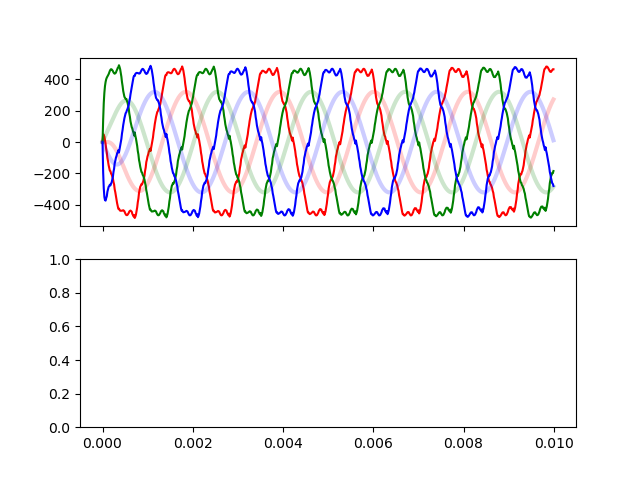

In [113]:
fig,axes = plt.subplots(nrows=2, sharex=True)

colors = ['r','g','b']
for it,item in enumerate(['v_a','v_b','v_c']):
    axes[0].plot(Z_1['t'], Z_1[item],label=item,color=colors[it],lw=3,alpha=0.2)
    axes[0].plot(Z_5['t'], Z_5['v_abc'][:,it],label=item,color=colors[it])


In [35]:
simulink = sio.loadmat('./simulink/pmsm_simulink_10ohm.mat')

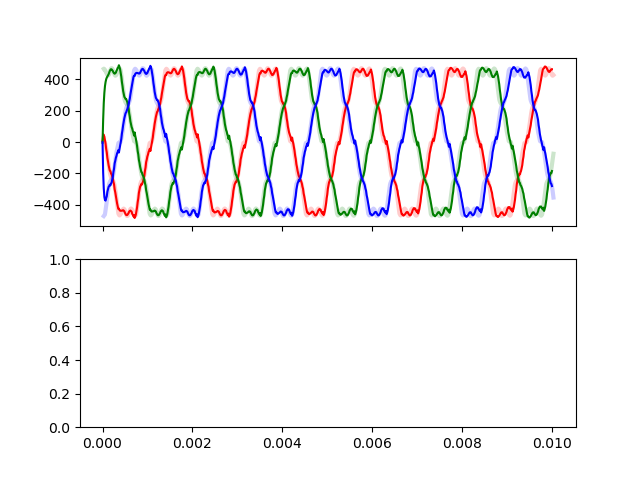

In [114]:
fig,axes = plt.subplots(nrows=2, sharex=True)

colors = ['r','g','b']
for it,item in enumerate(['v_a','v_b','v_c']):
    axes[0].plot(simulink['simout'][:,0]+2.7000000000000114e-05,simulink['simout'][:,it+1],color=colors[it],lw=3, alpha=0.2)
    axes[0].plot(Z_5['t'], Z_5['v_abc'][:,it],label=item,color=colors[it])
    


In [49]:
0.004756-0.004783

-2.7000000000000114e-05